In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
import zarr
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [2]:
# Pupil plane
n_p = 32
size_p = 8.0
pitch_p = size_p / n_p
z_p = 0.0

# View plane
n_v = 1440
size_v = 360.0
pitch_v = size_v / n_v
z_v = 176.0

# Field of view
fov_factor = (size_v - size_p) / z_v
fov = 2 * np.arctan(fov_factor / 2) * 180/np.pi

# Retina estimate
lf_n_r = n_v - n_p

print('[Sampled Light Field]')
print('Pupil Plane:     {:4} × {:4.2f} mm = {:5} mm         \t    z_p = {:5} mm'.format(n_p, pitch_p, size_p, z_p))
print('View Plane:      {:4} × {:4.2f} mm = {:5} mm         \t    z_v = {:5} mm'.format(n_v, pitch_v, size_v, z_v))
print('Retina Estimate: {:7.2f} samples over FoV = {:4.1f}° \t z_near = {:5} mm'.format(lf_n_r, fov, z_v/2))

print('\nNumber of rays:', f'{(n_p * n_v)**2:,}')

[Sampled Light Field]
Pupil Plane:       32 × 0.25 mm =   8.0 mm         	    z_p =   0.0 mm
View Plane:      1440 × 0.25 mm = 360.0 mm         	    z_v = 176.0 mm
Retina Estimate: 1408.00 samples over FoV = 90.0° 	 z_near =  88.0 mm

Number of rays: 2,123,366,400


In [3]:
# Plane A
n_a = 48
z_a = 8.0
size_a = size_p + fov_factor * z_a
pitch_a = size_a / n_a

# Plane B
n_b = 560
z_b = 136.0
size_b = size_p + fov_factor * z_b
pitch_b = size_b / n_b

# Retina estimate
ab_n_r = fov_factor * (z_b - z_a) / max(pitch_a, pitch_b)

print('[Display Light Field]')
print('Plane A:         {:4} × {:4.2f} mm = {:5} mm         \t    z_a = {:5} mm'.format(n_a, pitch_a, size_a, z_a))
print('Plane B:         {:4} × {:4.2f} mm = {:5} mm         \t    z_b = {:5} mm'.format(n_b, pitch_b, size_b, z_b))
print('Retina Estimate: {:7.2f} samples over FoV = {:4.1f}° \t z_near = {:5} mm'.format(ab_n_r, fov, z_b/2))

print('\nNumber of elements:', f'{(n_a * n_b)**2:,}')

[Display Light Field]
Plane A:           48 × 0.50 mm =  24.0 mm         	    z_a =   8.0 mm
Plane B:          560 × 0.50 mm = 280.0 mm         	    z_b = 136.0 mm
Retina Estimate:  512.00 samples over FoV = 90.0° 	 z_near =  68.0 mm

Number of elements: 722,534,400


In [4]:
def array_stats(a):
    print('shape: ', a.shape, a.dtype, '| total size:', a.nbytes/2**30, 'GiB | range: [', np.amin(a), ',', np.amax(a), '] | average: ', np.average(a))



def sampling_lattice(n, pitch=1.0):
    return (np.arange(n) - (n - 1)/2).astype(np.float32) * pitch


    
def display_image(values, absolute=False, normalize=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = values.T
    values = np.abs(values) if absolute else values
    values = np.flip(values, axis=1) if flip else np.flip(values, axis=0)
    values = (values * np.nan_to_num(255.0 / np.amax(values))).astype(np.uint8) if normalize else np.clip(values * 255.0, 0.0, 255.0).astype(np.uint8)
    display(Image.fromarray(values))

    

def dot(a, b):
    return np.einsum('...i,...i', a, b)

In [5]:
n_r = 512
pitch_r = fov_factor / n_r

focus_distances = np.array([250.0, np.inf])
n_f = len(focus_distances)

lattice_r = sampling_lattice(n_r, pitch_r)
lattice_p = sampling_lattice(n_p, pitch_p)
lattice_v = sampling_lattice(n_v, pitch_v)
lattice_a = sampling_lattice(n_a, pitch_a)
lattice_b = sampling_lattice(n_b, pitch_b)

In [6]:
%%time
print('Processing rays...')

naive_colors = np.zeros((3, n_a, n_b, n_a, n_b), dtype=np.float32)
naive_counts = np.zeros((3, n_a, n_b, n_a, n_b), dtype=np.int16)

retina_colors = np.zeros((n_f, 3, n_r, n_r), dtype=np.float32)
retina_counts = np.zeros((n_f, 1, n_r, n_r), dtype=np.int16)

light_field = zarr.open('data/sponza.zarr', mode='r')

xy_p  = np.stack(np.broadcast_arrays(lattice_p.reshape(n_p, 1), lattice_p.reshape(1, n_p)), axis=-1)
xy_v  = np.stack(np.broadcast_arrays(lattice_v.reshape(n_v, 1), lattice_v.reshape(1, n_v)), axis=-1)

for i_p, j_p in tqdm(np.ndindex(n_p, n_p), total=n_p*n_p):
    # Load ray values.
    lf_view = light_field[:, i_p, :, j_p, :]
    # Plane intersections.
    xy_a = (z_a/z_v) * xy_v + (1 - z_a/z_v) * xy_p[i_p, j_p]
    xy_b = (z_b/z_v) * xy_v + (1 - z_b/z_v) * xy_p[i_p, j_p]
    # Element indices.
    ij_a = np.clip(np.floor_divide(xy_a, pitch_a) + n_a/2, 0, n_a - 1).astype(np.uint32)
    ij_b = np.clip(np.floor_divide(xy_b, pitch_b) + n_b/2, 0, n_b - 1).astype(np.uint32)
    # Accumulate values.
    naive_colors[:, ij_a[..., 0], ij_b[..., 0], ij_a[..., 1], ij_b[..., 1]] += lf_view
    naive_counts[:, ij_a[..., 0], ij_b[..., 0], ij_a[..., 1], ij_b[..., 1]] += 1
    # For each focus distance...
    for index_f, z_f in np.ndenumerate(focus_distances):
        # Retina instersection.
        xy_r = (1/z_v) * xy_v + (1/z_f - 1/z_v) * xy_p[i_p, j_p]
        # Sample indices.
        ij_r = np.clip(np.floor_divide(xy_r, pitch_r) + n_r/2, 0, n_r - 1).astype(np.uint32)
        # Accumulate values.
        retina_colors[index_f][:, ij_r[..., 0], ij_r[..., 1]] += lf_view
        retina_counts[index_f][:, ij_r[..., 0], ij_r[..., 1]] += 1

naive_colors /= np.maximum(naive_counts, 1)
retina_colors /= np.maximum(retina_counts, 1)

Processing rays...


  0%|          | 0/1024 [00:00<?, ?it/s]

Wall time: 28min 9s


 
 
Observer focus distance = 250.0
Reference
shape:  (3, 512, 512) float32 | total size: 0.0029296875 GiB | range: [ 0.0 , 0.9993872 ] | average:  0.31668386


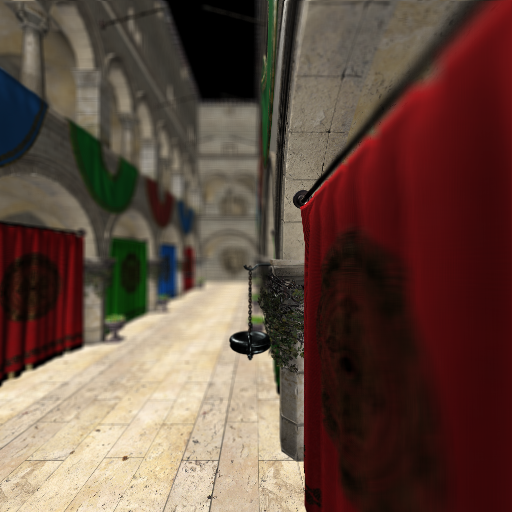

 
 
Observer focus distance = 250.0
Naive [Display Light Field]
shape:  (3, 512, 512) float32 | total size: 0.0029296875 GiB | range: [ 0.0 , 0.9904942 ] | average:  0.31422922


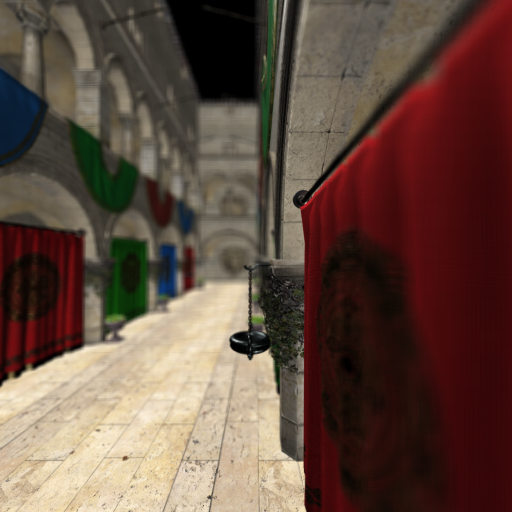

 
 
Observer focus distance = inf
Reference
shape:  (3, 512, 512) float32 | total size: 0.0029296875 GiB | range: [ 0.0 , 0.9856051 ] | average:  0.31672838


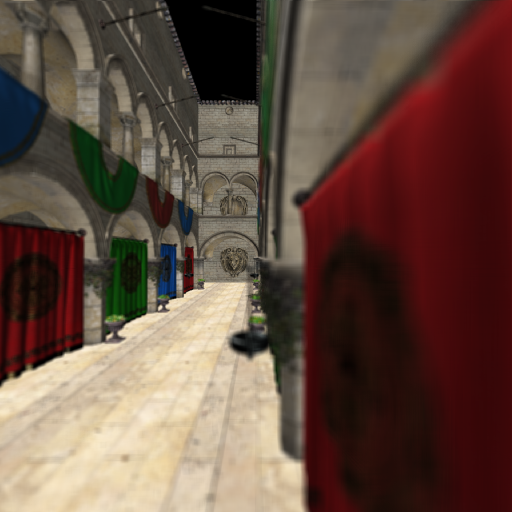

 
 
Observer focus distance = inf
Naive [Display Light Field]
shape:  (3, 512, 512) float32 | total size: 0.0029296875 GiB | range: [ 0.0 , 0.978016 ] | average:  0.31429848


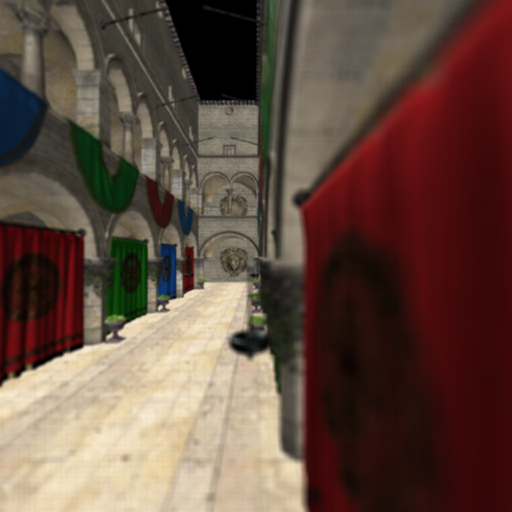

In [7]:
def evaluate_phi(x_r, z_r, x_a, z_a, w_a, x_b, z_b, w_b, z_f, size_p):
    """Value of φ for given 1d display element and retina position."""
    # Ratios for projection of plane A and plane B to the pupil plane.
    ratio_a = np.reciprocal(1.0 - z_a/z_f)
    ratio_b = np.reciprocal(1.0 - z_b/z_f)
    # Project display samples to the pupil plane.
    x_a_at_p = ratio_a * (x_a - (z_a/z_r) * x_r)
    x_b_at_p = ratio_b * (x_b - (z_b/z_r) * x_r)
    # Lower and upper bounds.
    lower_a = x_a_at_p - np.abs(ratio_a * w_a/2)
    upper_a = x_a_at_p + np.abs(ratio_a * w_a/2)
    lower_b = x_b_at_p - np.abs(ratio_b * w_b/2)
    upper_b = x_b_at_p + np.abs(ratio_b * w_b/2)
    # Pupil bounds.
    lower_bound = -size_p/2
    upper_bound = size_p/2
    # Intersect with the projections from A and B.
    lower_bound = np.clip(lower_bound, lower_a, upper_a)
    upper_bound = np.clip(upper_bound, lower_a, upper_a)
    lower_bound = np.clip(lower_bound, lower_b, upper_b)
    upper_bound = np.clip(upper_bound, lower_b, upper_b)
    # Return the value of φ, normalized by the pupil size.
    return (upper_bound - lower_bound) / size_p



x_r = lattice_r.reshape(n_r, 1, 1)
x_p = lattice_p.reshape(1, n_p, 1)
x_v = lattice_v.reshape(1, 1, n_v)
x_a = lattice_a.reshape(1, n_a, 1)
x_b = lattice_b.reshape(1, 1, n_b)

retina_image = np.zeros((3, n_r, n_r), dtype=np.float32)

# For each focus distance...
for index_f, z_f in np.ndenumerate(focus_distances):
    #phi_rpv = cp.array(evaluate_phi(x_r, 1.0, x_p, z_p, pitch_p, x_v, z_v, pitch_v, z_f, size_p).reshape(n_r, n_p * n_v))
    phi_rab = cp.array(evaluate_phi(x_r, 1.0, x_a, z_a, pitch_a, x_b, z_b, pitch_b, z_f, size_p).reshape(n_r, n_a*n_b))
    
    print(' \n \nObserver focus distance =', z_f)
    print('Reference')
    retina_image = retina_colors[index_f]
    array_stats(retina_image)
    display_image(retina_image)

    #print(' \n \nObserver focus distance =', z_f)
    #print('Naive [Sampled Light Field]')
    #for k in range(3):
    #    retina_image[k] = (phi_rpv @ cp.array(light_field[k]) @ phi_rpv.T).get()
    #array_stats(retina_image)
    #display_image(retina_image)

    print(' \n \nObserver focus distance =', z_f)
    print('Naive [Display Light Field]')
    for k in range(3):
        retina_image[k] = (phi_rab @ cp.array(naive_colors[k].reshape(n_a*n_b, n_a*n_b)) @ phi_rab.T).get()
    array_stats(retina_image)
    display_image(retina_image)